# Park Anomaly
a. stein 3/8/22

Develop functions to plot and extract anomalies for park data.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd

import rioxarray
from shapely.geometry import mapping

Populating the interactive namespace from numpy and matplotlib


Load in data

In [2]:
park_path = '/pool0/home/steinadi/data/drought/drought_impact/data/socio-econ'

nat_park_visits = xr.open_dataset(f'{park_path}/national_parks_v2.nc')
or_state_park_visits = xr.open_dataset(f'{park_path}/or_state_parks.nc')
wa_state_park_visits = xr.open_dataset(f'{park_path}/wa_state_parks.nc')

Get park names

In [3]:
nat_parks = nat_park_visits.park.values
wa_state_parks = wa_state_park_visits.park.values
or_state_parks = or_state_park_visits.park.values

Develop yearly plotting 

In [4]:
test_visits = nat_park_visits.isel(park=0)['Day Visits']
test_visits

<xarray.DataArray 'Day Visits' (time: 505)>
array([ 6771.,  5820., 10617., ..., 18270., 26100.,  8026.])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
    park     <U11 'Crater Lake'

Text(0.5, 1.0, 'Crater Lake')

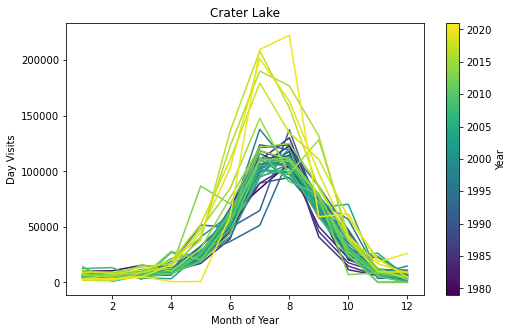

In [5]:
start_year = pd.to_datetime(test_visits.time.isel(time=0).values).year
end_year = pd.to_datetime(test_visits.time.isel(time=-1).values).year

fig, ax = plt.subplots(figsize=(8,5))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=start_year, vmax=end_year)
scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(scalar_mappable, label='Year')

for year in np.arange(start_year, end_year, 1):

    year_visits = test_visits.sel(time=slice(f'{year}',f'{year}'))
    month = pd.to_datetime(year_visits.time).month

    ax.plot(month, year_visits.values, color=cmap((year-start_year)/(end_year-start_year)))

ax.set_xlabel('Month of Year')
ax.set_ylabel('Day Visits')
ax.set_title(test_visits.park.values)

In [6]:
def plot_moy_overlay(da: xr.DataArray, ax=None, start_year=None, end_year=None, 
                    cmap=None, cbar=False, color=None, alpha=1, label=True):
    """Overlay each year of da by month of year.

    Parameters
    ----------
    da : xr.DataArray
        DataArray with parameters time and park expected.
    ax : matplotlib axis, (optional)
        What axis to plot on, all years are plotted on the same axis. If
        None is provided, one is created.
    start_year : int-like, (optional)
        Year to start plotting from.
    end_year : int-like, (optional)
        Last year to plot.
    cmap : matplotlib colormap, (optional)
        Color-coding for each year to create a color gradient as plotting
        progresses from start_year to end_year. If None is provided, default
        color is used instead.
    cbar : boolean, (optional)
        Whether to plot the colorbar on ax, defaults as False.
    color : string, (optional)
        If cmap is None, then colors each year the same with this parameter.
        If None is provided here, then matplotlib defaults are used.
    alpha : float, (optional)
        Transparency of each year plotted, uniform for all years, defaults 1.
    label : boolean, (optional)
        Whether to label the axis and title of ax, defaults as True. If you
        are planning ot use figure labels, then consider turning this to 
        False to reduce clutter. Assumes that y is Day Visits and that da
        has a dimension called park.
    
    Returns
    -------
    ax : matplotlib axis
        The axis object plotted on.
    """
    # check if given years to start/end, and set them to the start/end of the da
    # if not given
    if start_year is None:
        start_year = pd.to_datetime(da.time.isel(time=0).values).year
    if end_year is None:
        end_year = pd.to_datetime(da.time.isel(time=-1).values).year

    # see if we need to create an axis object
    if ax is None:
        __, ax = plt.subplots()

    # check if we want to plot the colorbar
    if cbar:
        # double check that they actually gave a cmap
        if cmap is None:
            raise Exception('Please specify a cmap if you wish to plot a colorbar')
        # plot the colorbar
        norm = mpl.colors.Normalize(vmin=start_year, vmax=end_year)
        scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        plt.colorbar(scalar_mappable, label='Year')

    # plot by slicing years, (don't forget the +1 so we
    # actually end up plottin the last year!)
    for year in np.arange(start_year, end_year+1, 1):
        # quick little slice and grab the months to plot
        year_da = da.sel(time=slice(f'{year}',f'{year}'))
        month = pd.to_datetime(year_da.time).month

        # if we were given a cmap, we need to specify the color via the cmap
        if cmap:
            ax.plot(month, year_da.values, color=cmap((year-start_year)/(end_year-start_year)), alpha=alpha)
        # otherwise we can assign whatever color is given
        else:
            ax.plot(month, year_da.values, color=color, alpha=alpha)

    # check if want to label and do so if so (may not want to if applying suplabels)
    if label:
        ax.set_xlabel('Month of Year')
        ax.set_ylabel('Day Visits')
        ax.set_title(da.park.values);

    return ax

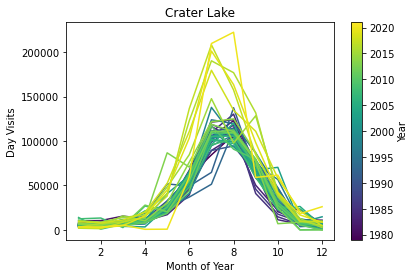

In [7]:
plot_moy_overlay(test_visits, cmap=plt.cm.get_cmap('viridis'), cbar=True);

Okay, cool, so that get's us a sense of how the years compare ... let's try some statistics and see if we can pull out anomalies.

I have monthly data, so I want to groupby month.

Text(0.5, 1.0, 'Crater Lake')

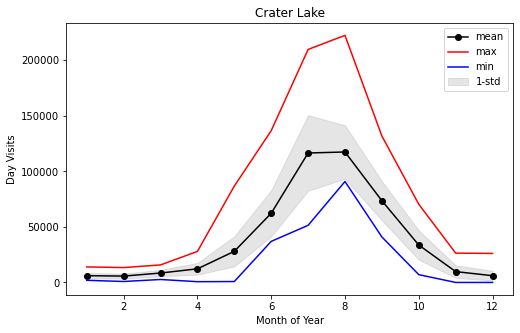

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

month_visits = test_visits.groupby("time.month")

month_mean = month_visits.mean()
month_std = month_visits.std()

month_max = month_visits.max()
month_min = month_visits.min()

ax.plot(month_mean.month, month_mean.values, color='k', label='mean', marker='o')
ax.plot(month_max.month, month_max.values, color='r', label='max')
ax.plot(month_min.month, month_min.values, color='b', label='min')
ax.fill_between(month_std.month, month_mean.values+month_std.values, month_mean.values-month_std.values, color='grey', alpha=0.2, label='1-std')

ax.legend()
ax.set_xlabel('Month of Year')
ax.set_ylabel('Day Visits')
ax.set_title(test_visits.park.values)

Wrap this into a function. I'm disappointed that xarray doesn't have an `agg` function for their `groupby` like `pandas`, so I'm making my own.

In [9]:
def da_summary_stats(da:xr.DataArray, stats, groupby="time.month"):
    """Compute summary statistics for da.

    Parameters
    ----------
    da : xr.DataArray
        Data to compute stats on.
    stats : str or list-like
        What stats to compute from the following options:
            'mean' - computes the mean over groupby
            'median' - computes the median over groupby
            'std' - computes the standard deviation over groupby
            'max' - computes the maximum over groupby
            'min' - computes the minimum over groupby
        This is case-insensitive but must be one of the above options.
        You can specify as just one of them (such as stats='mean'), or
        provide them as a list-like object that is iterable. The order
        provided in stats does not change the order of stats provided
        in the returned object. Any misspelled specifications will
        simply not be computed.
    groupby : xr.DataArray.groupby suitable
        How to group the values in da, defaults as 'time.month'.

    Returns
    -------
    list or xr.DataArray
        List of xr.DataArray objects based on what is specified in stats
        in the following order: [mean, median, std, max, min]. If any
        of the five stats was not specified, then it is not included in the
        return list, but the order follows the same scheme excluding that
        statistic. If only one value was specified in stats, then returned
        DataArray is not wrapped in a list and can be accessed without
        unwrapping.
    """

    # I'm going to want to check through a list, yet I want to
    # make it compatible for only providing the name of one and
    # not be silly by requiring a string wrapper, so let's put it
    # in a list if not already
    if isinstance(stats, str):
        stats = [stats]

    # do a quick swap around to get everything lowercase
    stats_temp = stats
    stats = []
    for stat in stats_temp:
        assert isinstance(stat, str)
        stats.append(stat.lower())
    stats_temp = None

    # group the dataarray by whatever is given
    da_grouped = da.groupby(groupby)
    
    # start collecting statistics that we want to compute
    computed_stats = []
    if 'mean' in stats:
        mean = da_grouped.mean()
        computed_stats.append(mean)
    if 'median' in stats:
        median = da_grouped.median()
        computed_stats.append(median)
    if 'std' in stats:
        std = da_grouped.std()
        computed_stats.append(std)
    if 'max' in stats:
        max = da_grouped.max()
        computed_stats.append(max)
    if 'min' in stats:
        min = da_grouped.min()
        computed_stats.append(min)

    # want to catch if there was a typo and nothing was actually computed
    if len(computed_stats)==0:
        raise Exception('Please revise your stats input to be one of the specified options.')
    # it's a little stilly to need to unwrap just one
    # dataarray if we only computed one thing, so will
    # just unwrap it here
    if len(computed_stats)==1:
        return computed_stats[0]
    else:
        return computed_stats

Test our function

In [10]:
mean = da_summary_stats(test_visits, 'mean')
mean == month_mean

<xarray.DataArray 'Day Visits' (month: 12)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])
Coordinates:
    park     <U11 'Crater Lake'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [11]:
mean, std, max, min = da_summary_stats(test_visits, ['mean','Std', 'MAX', 'mIN'])

std == month_std

<xarray.DataArray 'Day Visits' (month: 12)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])
Coordinates:
    park     <U11 'Crater Lake'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [12]:
max == month_max

<xarray.DataArray 'Day Visits' (month: 12)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])
Coordinates:
    park     <U11 'Crater Lake'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [13]:
min == month_min

<xarray.DataArray 'Day Visits' (month: 12)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])
Coordinates:
    park     <U11 'Crater Lake'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Awesome, that works well.

In [14]:
def plot_summary_stats(da:xr.DataArray, ax=None, line_colors=['k','r','b'], std_color='grey', std_alpha=0.2, label=True):
    """Plots summary statistics of da, including mean, max, min, and one standard deviation range.

    Parameters
    ----------
    da : xr.DataArray
        Data to plot.
    ax : matplotlib axis object, (optional)
        What to plot da on. If no ax is provided, one will be created.
    line_colors : list, (optional)
        Colors to plot the line data, (mean, max, and min in that order).
        Defaults as ['k', 'r', 'b'].
    std_color : str, (optional)
        Fill color for 1-std range, defaults as 'grey'.
    std_alpha : float, (optional)
        Transparency for 1-std range filled area, defaults as 0.2.
    label : boolean, (optional)
        Whether to label the axis and title assuming this as a parks
        dataset that is plotting 'Day Visits' on the y-axis, and 
        can call da.park.values to get the name of the park plotted.
        Turn this off for other data or to declutter.
    """
    if ax is None:
        __, ax = plt.subplots()
    
    mean, std, max, min = da_summary_stats(da, ['mean','std','max','min'])
    
    for color, stat, name in zip(line_colors, [mean, max, min], ['Mean', 'Max', 'Min']):
        ax.plot(stat.month, stat.values, color=color, label=name)
    ax.fill_between(mean.month, mean.values-std.values, mean.values+std.values, 
    color=std_color, alpha=std_alpha, label='1-STD')
    
    if label:
        ax.legend()
        ax.set_xlabel('Month of Year')
        ax.set_ylabel('Day Visits')
        ax.set_title(da.park.values)

    return ax

<AxesSubplot:title={'center':'Crater Lake'}, xlabel='Month of Year', ylabel='Day Visits'>

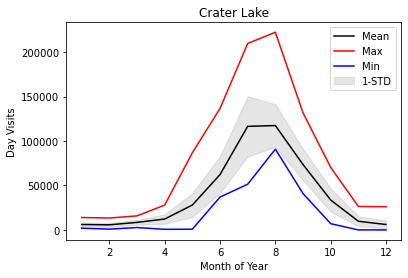

In [15]:
plot_summary_stats(da=test_visits)

fig, ax = plt.subplots(figsize=(8,5))

colors = ['k', 'r', 'b']
stats = ['mean', 'max', 'min']

for color, stat in zip(colors, stats):
    stat_da = da_summary_stats(test_visits, stat)
    ax.plot(stat_da.month, stat_da.values, color=color, label=stat)

mean, std = da_summary_stats(test_visits, ['mean','std'])
ax.fill_between(mean.month, mean.values-std.values, mean.values+std.values, color='grey', alpha=0.2, label='1-std')

ax.legend()
ax.set_xlabel('Month of Year')
ax.set_ylabel('Day Visits')
ax.set_title(test_visits.park.values)

I like that, much cleaner and easier to 

start_year = pd.to_datetime(test_visits.time.isel(time=0).values).year
end_year = pd.to_datetime(test_visits.time.isel(time=-1).values).year

fig, ax = plt.subplots(figsize=(8,5))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=start_year, vmax=end_year)
scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(scalar_mappable, label='Year')

for year in np.arange(start_year, end_year, 1):

    year_visits = test_visits.sel(time=f'{year}') - month_mean.values
    month = pd.to_datetime(year_visits.time).month

    ax.plot(month, year_visits.values, color=cmap((year-start_year)/(end_year-start_year)))

ax.set_xlabel('Month of Year')
ax.set_ylabel('Deviation from Mean ('r'$DV_i-Mean$'')')
ax.set_title(test_visits.park.values)

plt.tight_layout()

(ended up writing that `plot_moy_overlay` function and simplifying the notebook)

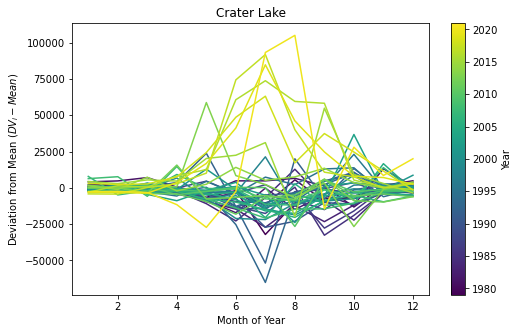

In [16]:
fig, ax = plt.subplots(figsize=(8,5))

diff_from_mean = test_visits.copy()
for year in np.arange(start_year, end_year, 1):
    diff_from_mean.loc[{'time':f'{year}'}] -= month_mean.values

plot_moy_overlay(diff_from_mean, cmap=plt.cm.get_cmap('viridis'), cbar=True, ax=ax)
ax.set_ylabel('Deviation from Mean ('r'$DV_i-Mean$'')');

What if I normalize it ...

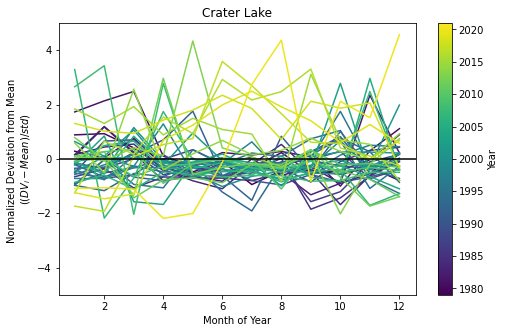

In [17]:
fig, ax = plt.subplots(figsize=(8,5))

std_diff_from_mean = test_visits.copy()
for year in np.arange(start_year, end_year, 1):
    yearly_val = std_diff_from_mean.loc[{'time':f'{year}'}]
    std_diff_from_mean.loc[{'time':f'{year}'}] = (yearly_val - month_mean.values)/month_std.values

plot_moy_overlay(std_diff_from_mean, cmap=plt.cm.get_cmap('viridis'), cbar=True, ax=ax)
ax.set_ylabel('Normalized Deviation from Mean \n'r'$((DV_i-Mean)/std)$')
# need to set the ylim by hand for some reason ...
ax.set_ylim(-5, 5)
ax.axhline(0, color='k')

start_year = pd.to_datetime(test_visits.time.isel(time=0).values).year
end_year = pd.to_datetime(test_visits.time.isel(time=-1).values).year

fig, ax = plt.subplots(figsize=(8,5))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=start_year, vmax=end_year)
scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(scalar_mappable, label='Year')

for year in np.arange(start_year, end_year, 1):

    year_visits = (test_visits.sel(time=slice(f'{year}',f'{year}')) - month_mean.values)/month_std.values
    month = pd.to_datetime(year_visits.time).month

    ax.plot(month, year_visits.values, color=cmap((year-start_year)/(end_year-start_year)))

ax.set_xlabel('Day of Year')
ax.set_ylabel('Normalized Deviation from Mean \n'r'$((DV_i-Mean)/std)$')
ax.set_title(test_visits.park.values)
ax.set_ylim(-5,5)
ax.axhline(0, color='k')

plt.tight_layout()

Wow. I am not really sure how to get a signal out of that.

I need to do some filtering ... but also there is already so little data.

What if I try to detect a difference in means.

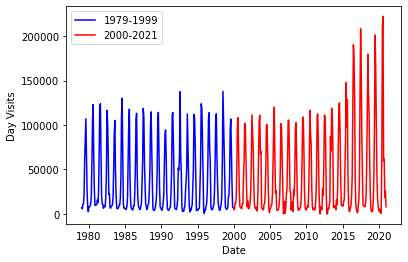

In [18]:
event_year = 1999
pre_event = test_visits.sel(time=slice(f'{start_year}',f'{event_year}'))
post_event = test_visits.sel(time=slice(f'{event_year+1}',f'{end_year}'))

fig, ax = plt.subplots()
ax.plot(pre_event.time, pre_event.values, color='b', label=f'{start_year}-{event_year}')
ax.plot(post_event.time, post_event.values, color='r', label=f'{event_year+1}-{end_year}')

ax.set_xlabel('Date')
ax.set_ylabel('Day Visits')
ax.legend();

I've now gone through and wrapped the above plots (besides the one directly above) into functions and such.

fig, ax = plt.subplots()

plot_summary_stats(pre_event, ax=ax, line_colors=['b','b','b'], std_color='b')
plot_summary_stats(post_event, ax=ax, line_colors=['r','r','r'], std_color='r')

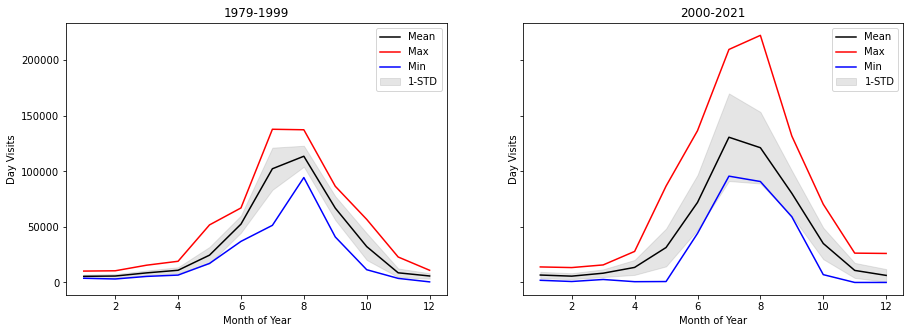

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True, sharex=True)

plot_summary_stats(pre_event, ax=axs[0])
axs[0].set_title(f'{start_year}-{event_year}')
plot_summary_stats(post_event, ax=axs[1])
axs[1].set_title(f'{event_year+1}-{end_year}');

Tried putting them on the same axis, that was a disaster, at least with different colors. Also tried all same color for each timeset ... that was also not great although an improvement.

In [20]:
pre_mean, pre_std, pre_max, pre_min = da_summary_stats(pre_event, ['mean','std','max','min'])
post_mean, post_std, post_max, post_min = da_summary_stats(post_event, ['mean', 'std', 'max', 'min'])

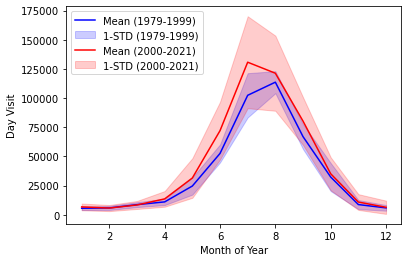

In [21]:
fig, ax = plt.subplots()

for color, mean, std, label, in zip(['b', 'r'], [pre_mean, post_mean], [pre_std, post_std], [f'{start_year}-{event_year}', f'{event_year+1}-{end_year}']):
    ax.plot(mean.month, mean.values, color=color, label=f'Mean ({label})')
    ax.fill_between(mean.month, mean.values-std.values, mean.values+std.values, color=color, label=f'1-STD ({label})', alpha=0.2)

ax.set_xlabel('Month of Year')
ax.set_ylabel('Day Visit')
ax.legend()

Well that gets them on the same plot ... not sure if worth it. Going to move on to performing stats.

So I want to see if the mean changes from one sample to another, indicating some sort of change happened in visitation. Doing a two-sample Z test is my best first bet, so let's check if we meet central limit theorem requirements (n>30) and the data is approximately normally distributed.

In [22]:
print(f'Pre-event n = {len(pre_event.time)}')
print(f'Post-event n = {len(post_event.time)}')

Pre-event n = 252
Post-event n = 253


We are good on the number of samples, let's check if we're normally distributed.

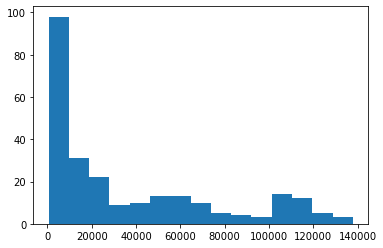

In [23]:
plt.hist(pre_event, bins=int(np.sqrt(252)));

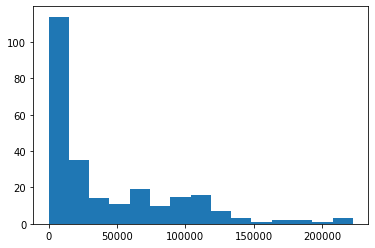

In [24]:
plt.hist(post_event, bins=int(np.sqrt(252)));

That is definitely not a normal distribution.

What about all the data?

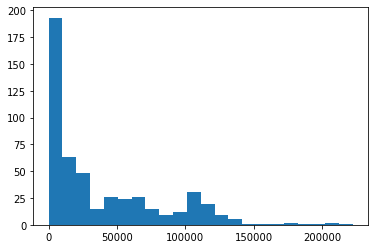

In [25]:
plt.hist(test_visits, bins=int(np.sqrt(len(test_visits.time))));

Looks like I get to do some statistics reading.

What if I do a log transform (need to use `log1p` cause there are some zeros in there ...)

In [29]:
bins = int(np.sqrt(len(test_visits.time)))
bins

22

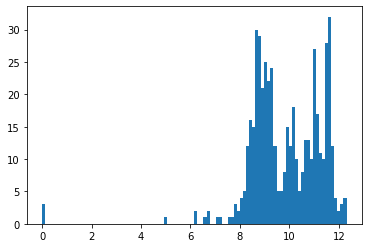

In [34]:
plt.hist(np.log1p(test_visits), bins=100);

Welll that's vaguely bimodal ... still not a normal distribution even if I clip that outlier ... but the grouping is better so may keep that in mind ...

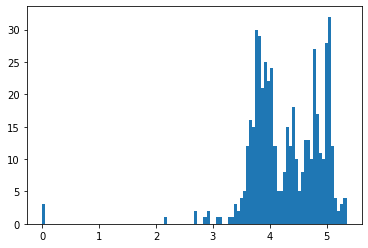

In [35]:
plt.hist(np.log10(test_visits+1), bins=100);

Was curious if doing a base 10 wuld change much ... and eh?

Real quick, how do the other parks look?

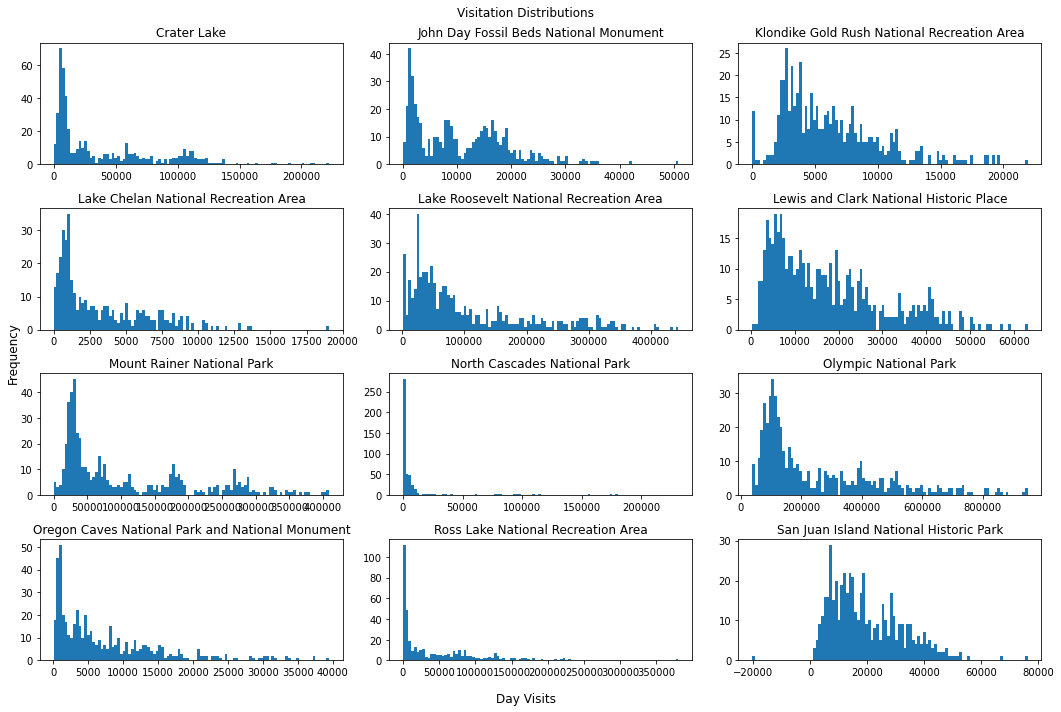

In [45]:
fig, axs = plt.subplots(4,3, figsize=(15,10))

for park, ax in zip(nat_park_visits.park.values, axs.ravel()):
    ax.hist(nat_park_visits.sel(park=park)['Day Visits'], bins=100)
    ax.set_title(f'{park}')
    
fig.supxlabel('Day Visits')
fig.supylabel('Frequency')
fig.suptitle('Visitation Distributions')

plt.tight_layout()

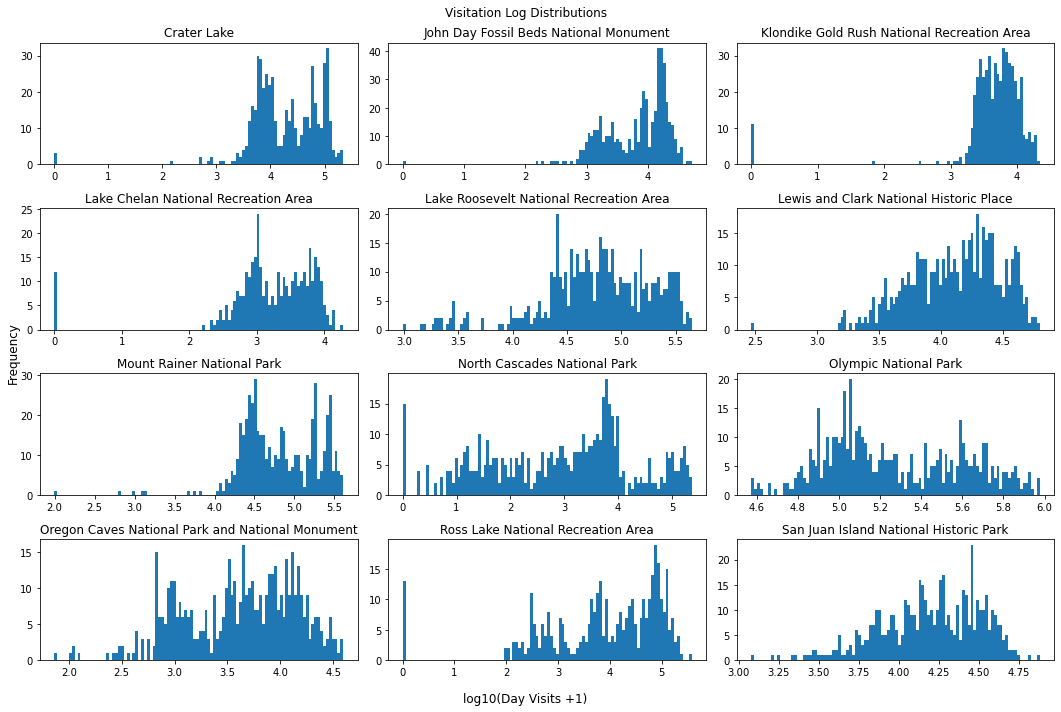

In [47]:
fig, axs = plt.subplots(4,3, figsize=(15,10))

for park, ax in zip(nat_park_visits.park.values, axs.ravel()):
    ax.hist(np.log10(nat_park_visits.sel(park=park)['Day Visits']+1), bins=100)
    ax.set_title(f'{park}')
    
fig.supxlabel('log10(Day Visits +1)')
fig.supylabel('Frequency')
fig.suptitle('Visitation Log Distributions')

plt.tight_layout()